# Data Preparation

In [1]:
%load_ext autoreload
%autoreload 2

# Load libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [3]:
usecols = ['misspayment_days',
'date',
'date_code',
'misspayment_days_90d_12m',
'total_balance',
'client_id',
'income',
'age',
'mortgage',
'mortgage_qty',
'maturity_months',
'monthly_payment',
'subsidy',
'interest_rate_fixed',
'default_120_12m']

In [4]:
df = pd.read_csv("../data/dataset_1/raw/dataset.csv", usecols=usecols)

# Descriptive Analysis

In [5]:
date_code_mapping = dict(df.groupby(["date","date_code"])["default_120_12m"].mean().index)

In [6]:
df['date'] = pd.to_datetime(df['date'])

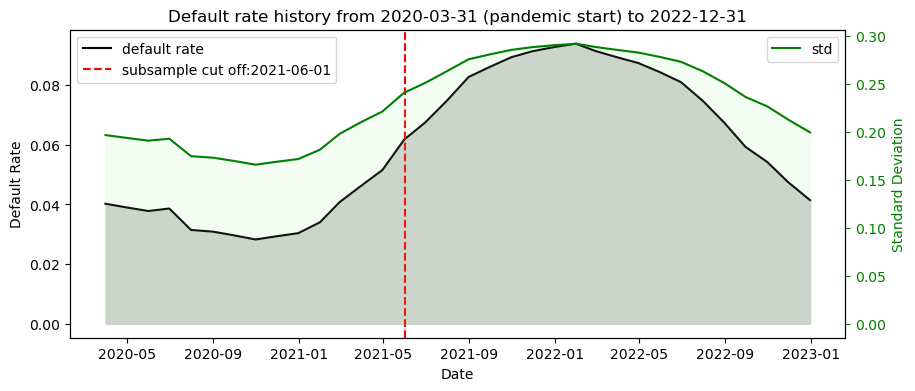

In [7]:
# Create the primary axis
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot the first series on the primary axis
ax1.plot(df.groupby("date")["default_120_12m"].mean().index, df.groupby("date")["default_120_12m"].mean(), color='black',linestyle='-', label='default rate')

ax1.set_xlabel('Date')
ax1.set_ylabel('Default Rate', color='black')  # Adjust color as needed
ax1.tick_params(axis='y', colors='black')  # Adjust color as needed

# Create the secondary axis
ax2 = ax1.twinx()

# Plot the second series on the secondary axis
ax2.plot(df.groupby("date")["default_120_12m"].mean().index, df.groupby("date")["default_120_12m"].std(), color='green',linestyle='-', label='std')

ax2.set_ylabel('Standard Deviation', color='green')
ax2.tick_params(axis='y', colors='green')

# Add legends and show the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add a vertical line
ax1.axvline(pd.Timestamp('2021-06-01'), color="r", linestyle='--', label= "subsample cut off:2021-06-01")
# shadow below ax1.plot

ax1.fill_between(df.groupby("date")["default_120_12m"].mean().index, df.groupby("date")["default_120_12m"].mean(), color='lightgrey', alpha=1)
ax2.fill_between(df.groupby("date")["default_120_12m"].std().index, df.groupby("date")["default_120_12m"].std(), color='lightgreen', alpha=0.1)

# shadow before axvline

# Set title
plt.title("Default rate history from 2020-03-31 (pandemic start) to 2022-12-31")
ax1.legend()

plt.savefig("../imgs/1_dataprep/total_default_rate_history.png", dpi=300)
# Show the plot
plt.show()

# Filter data and undersampling

In [8]:
filtercols = ['misspayment_days',
'date_code',
'misspayment_days_90d_12m',
'total_balance',
'client_id',
'income',
'age',
'mortgage',
'mortgage_qty',
'maturity_months',
'monthly_payment',
'subsidy',
'interest_rate_fixed',
'default_120_12m']

In [9]:
df_copy = df[filtercols].copy()

In [10]:
# for legibility rename cols
rename = {'misspayment_days': 'mispay_days',
          'misspayment_days_90d_12m':'mispay_d_90d_12m',
          'interest_rate_fixed':'interest_rate',
          }

In [11]:
df_copy = df_copy.rename(columns=rename)
df_copy = df_copy[df_copy["date_code"]  <= 20] # too large variation in data beyond this point

(12663, 14) 640 603


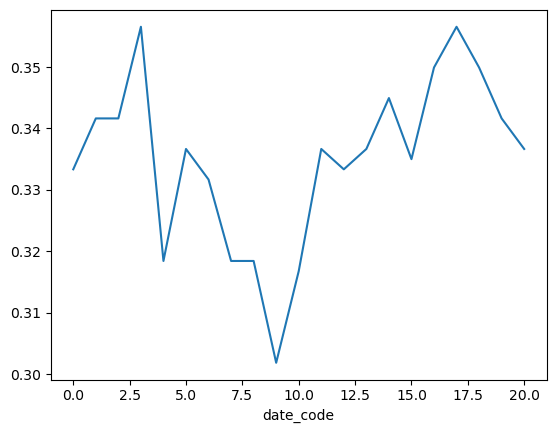

In [46]:
df_subsabmpled = df_copy.copy()
dmy = []
for i in df_subsabmpled.date_code.unique():
    a = df_subsabmpled[df_subsabmpled.date_code == i].copy()
    b, c, d, e, f, g, h =  [], [], [] , [], [], [], []
    if i <=10:
        f = a[a["default_120_12m"] == 1].sample(45-20).client_id.tolist()
        g = a[(a["default_120_12m"] == 0)].sample(20-5).client_id.tolist()   
    if i > 10 and i <=15:
        b = a[a["default_120_12m"] == 1].sample(12-2).client_id.tolist()
        c = a[a["default_120_12m"] == 0].sample(10-8).client_id.tolist()
    if i > 15:
        d = a[a["default_120_12m"] == 1].sample(16-8).client_id.tolist()
        e = a[a["default_120_12m"] == 0].sample(40-20).client_id.tolist()

    dmy.append(b+c+d+e+f+g)
    
# dmy = [df_subsabmpled.sample(250).client_id.tolist()]
# flatten list res
df_sublist = [item for sublist in dmy for item in sublist]

df_subset = df_subsabmpled[df_subsabmpled["client_id"].isin(df_sublist)]
df_subset["client_id"] = df_subset["client_id"].replace(dict(zip(df_subset.client_id.unique(), range(len(df_subset.client_id.unique())))))
df_subset.groupby('date_code')["default_120_12m"].mean().plot()
# train_subset = train_subset.set_index(["date_code", "client_id"])
print(df_subset.shape, len(df_sublist), len(set(df_sublist)))

In [47]:
CUTOFF = 15 # out of time set
train_subset = df_subset[df_subset["date_code"] <= CUTOFF].copy()
test_subset = df_subset[df_subset["date_code"] > CUTOFF].copy()

In [48]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train_subset.describe(include="all").T.round(20)

,count,mean,std,min,25%,50%,75%,max
mispay_days,9648.00,56.65,142.52,0.00,0.00,0.00,26.00,1584.00
date_code,9648.00,7.50,4.61,0.00,3.75,7.50,11.25,15.00
mispay_d_90d_12m,9648.00,136.17,221.63,0.00,4.00,41.00,149.00,1656.00
total_balance,9648.00,65629.95,81412.06,1956.05,30224.39,46276.99,68124.12,740685.44
client_id,9648.00,301.00,174.08,0.00,150.00,301.00,452.00,602.00
income,9648.00,907.99,443.13,712.83,788.48,842.36,925.70,10355.84
age,9648.00,43.19,11.21,24.00,34.00,42.00,51.00,75.00
mortgage,9648.00,79186.99,89517.33,12296.80,40000.00,56687.22,78351.00,783000.00
mortgage_qty,9648.00,1.05,0.22,1.00,1.00,1.00,1.00,2.00
maturity_months,9648.00,353.59,50.88,97.00,360.00,360.00,375.00,730.00


In [49]:
test_subset.describe(include="all").T.round(20)

,count,mean,std,min,25%,50%,75%,max
mispay_days,3015.00,68.96,179.02,0.00,0.00,0.00,26.50,1640.00
date_code,3015.00,18.00,1.41,16.00,17.00,18.00,19.00,20.00
mispay_d_90d_12m,3015.00,148.47,245.82,0.00,5.00,42.00,174.50,1656.00
total_balance,3015.00,65060.85,81254.16,2606.04,29242.39,45999.53,67859.05,734919.41
client_id,3015.00,301.00,174.10,0.00,150.00,301.00,452.00,602.00
income,3015.00,907.99,443.18,712.83,788.48,842.36,925.70,10355.84
age,3015.00,43.76,11.20,25.00,35.00,43.00,52.00,75.00
mortgage,3015.00,79111.81,89515.74,12296.80,40000.00,56254.10,78302.00,783000.00
mortgage_qty,3015.00,1.05,0.21,1.00,1.00,1.00,1.00,2.00
maturity_months,3015.00,362.76,63.19,132.00,360.00,360.00,384.00,730.00


In [50]:
from utils.constants import col_legibility_mapping

In [51]:
# computes correlation matrices for each month
res = []
for month in train_subset.date_code.unique():
    numcols = train_subset[train_subset.date_code==month].drop(["date_code",'client_id'], axis=1)
    numcols = numcols.rename(columns=col_legibility_mapping)
    corr = numcols.corr(method='pearson').values
    res.append(corr)
npres = np.stack(res)

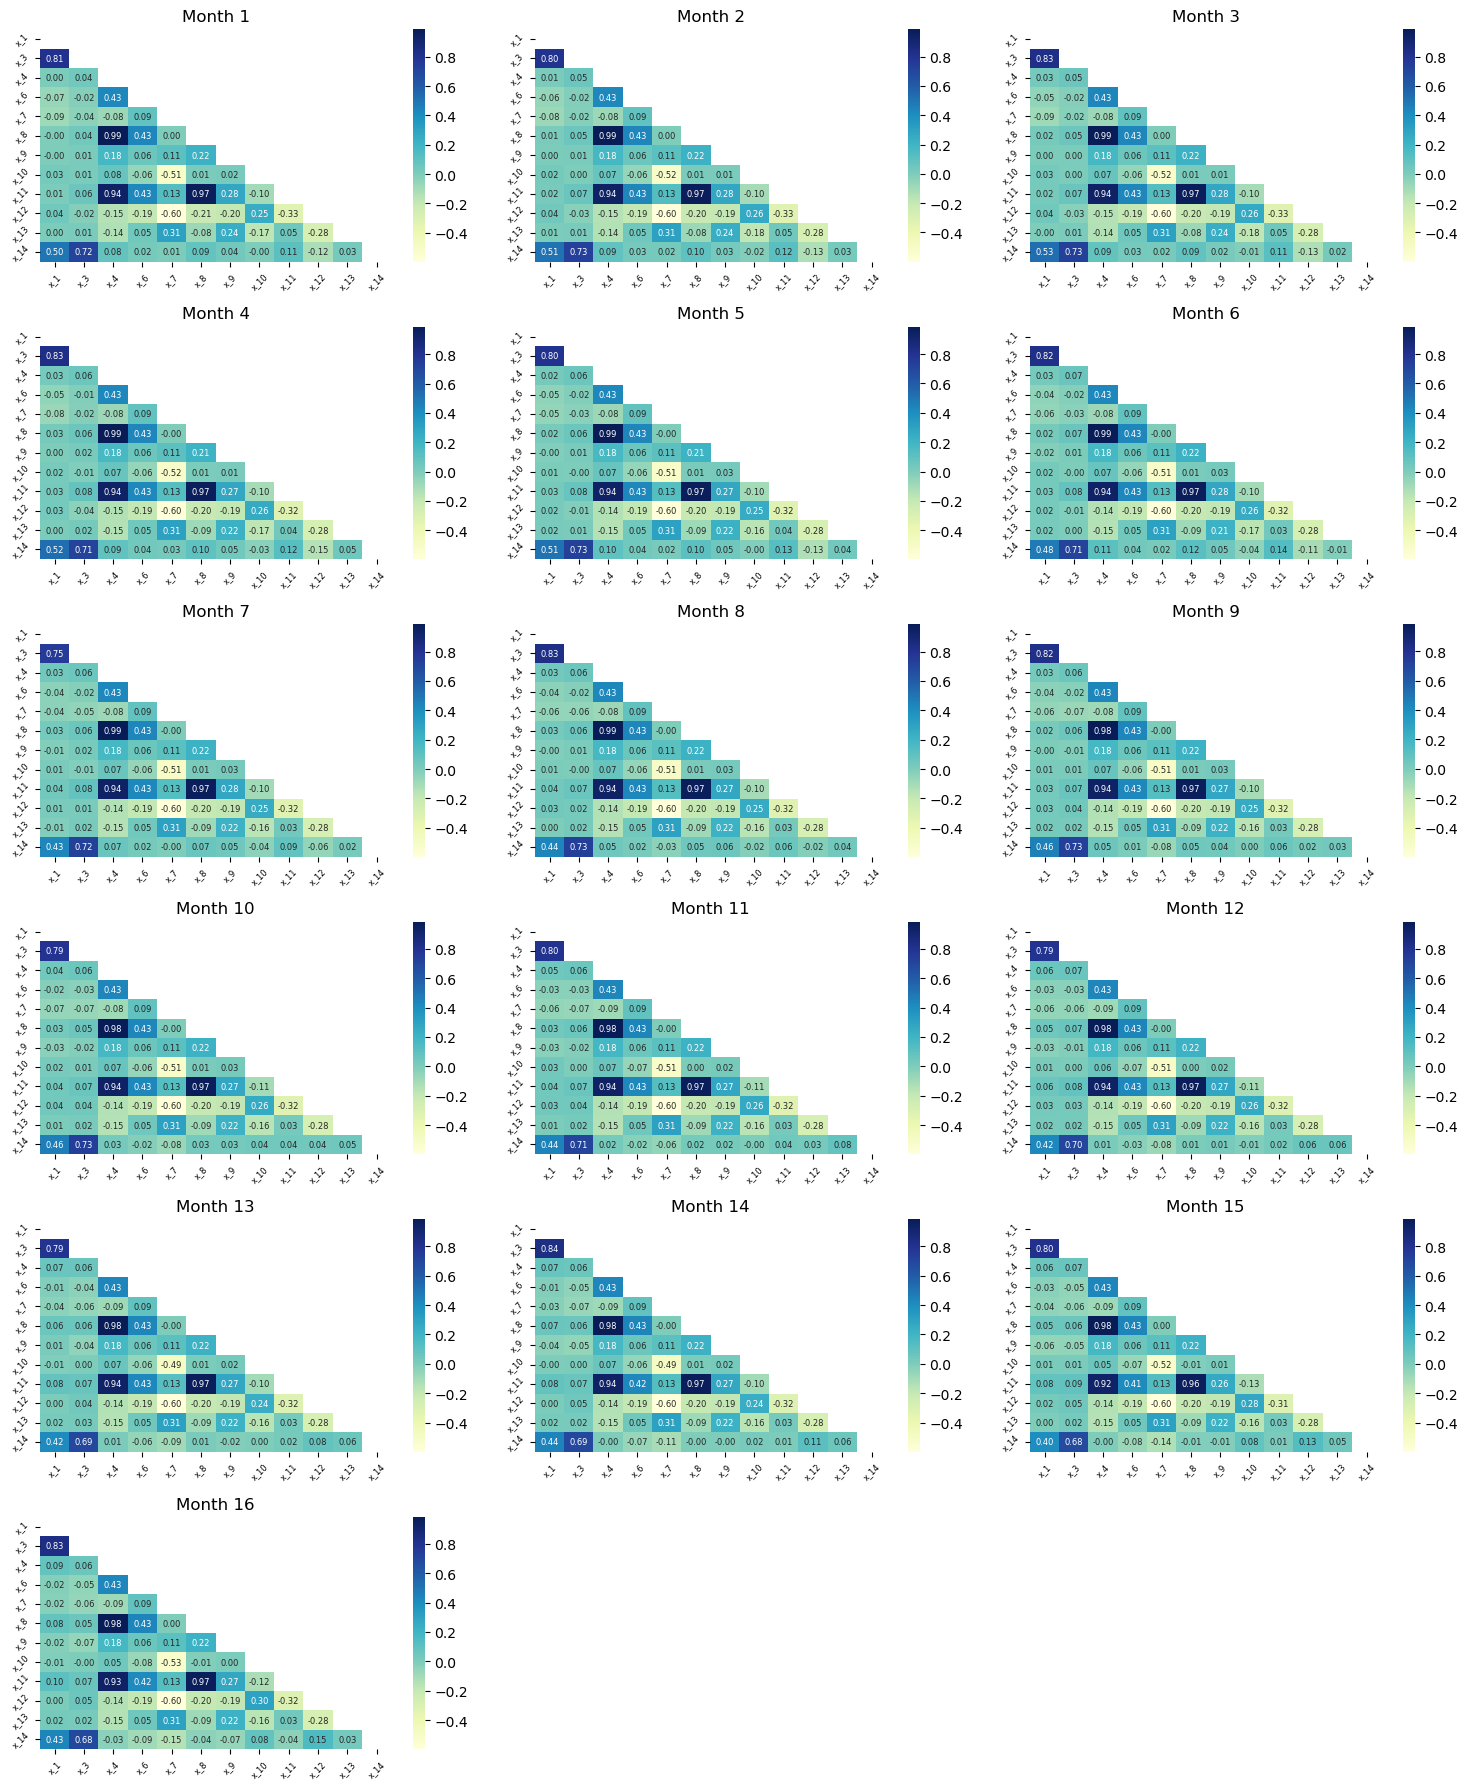

In [52]:
num_months = npres.shape[0]
num_cols = 3
num_rows = int(np.ceil(num_months / num_cols))

plt.figure(figsize=(15, 3 * num_rows))
mask = np.triu(np.ones_like(npres[0], dtype=bool))
for i in range(num_months):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.heatmap(pd.DataFrame(npres[i], columns=numcols.columns, index=numcols.columns), annot=True, fmt="1.2f", cmap='YlGnBu', mask=mask,  annot_kws={"size": 6})
    plt.title(f"Month {i + 1}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()
plt.savefig("../imgs/1_dataprep/correlation_monthly_plot.png", dpi=300)
plt.show()

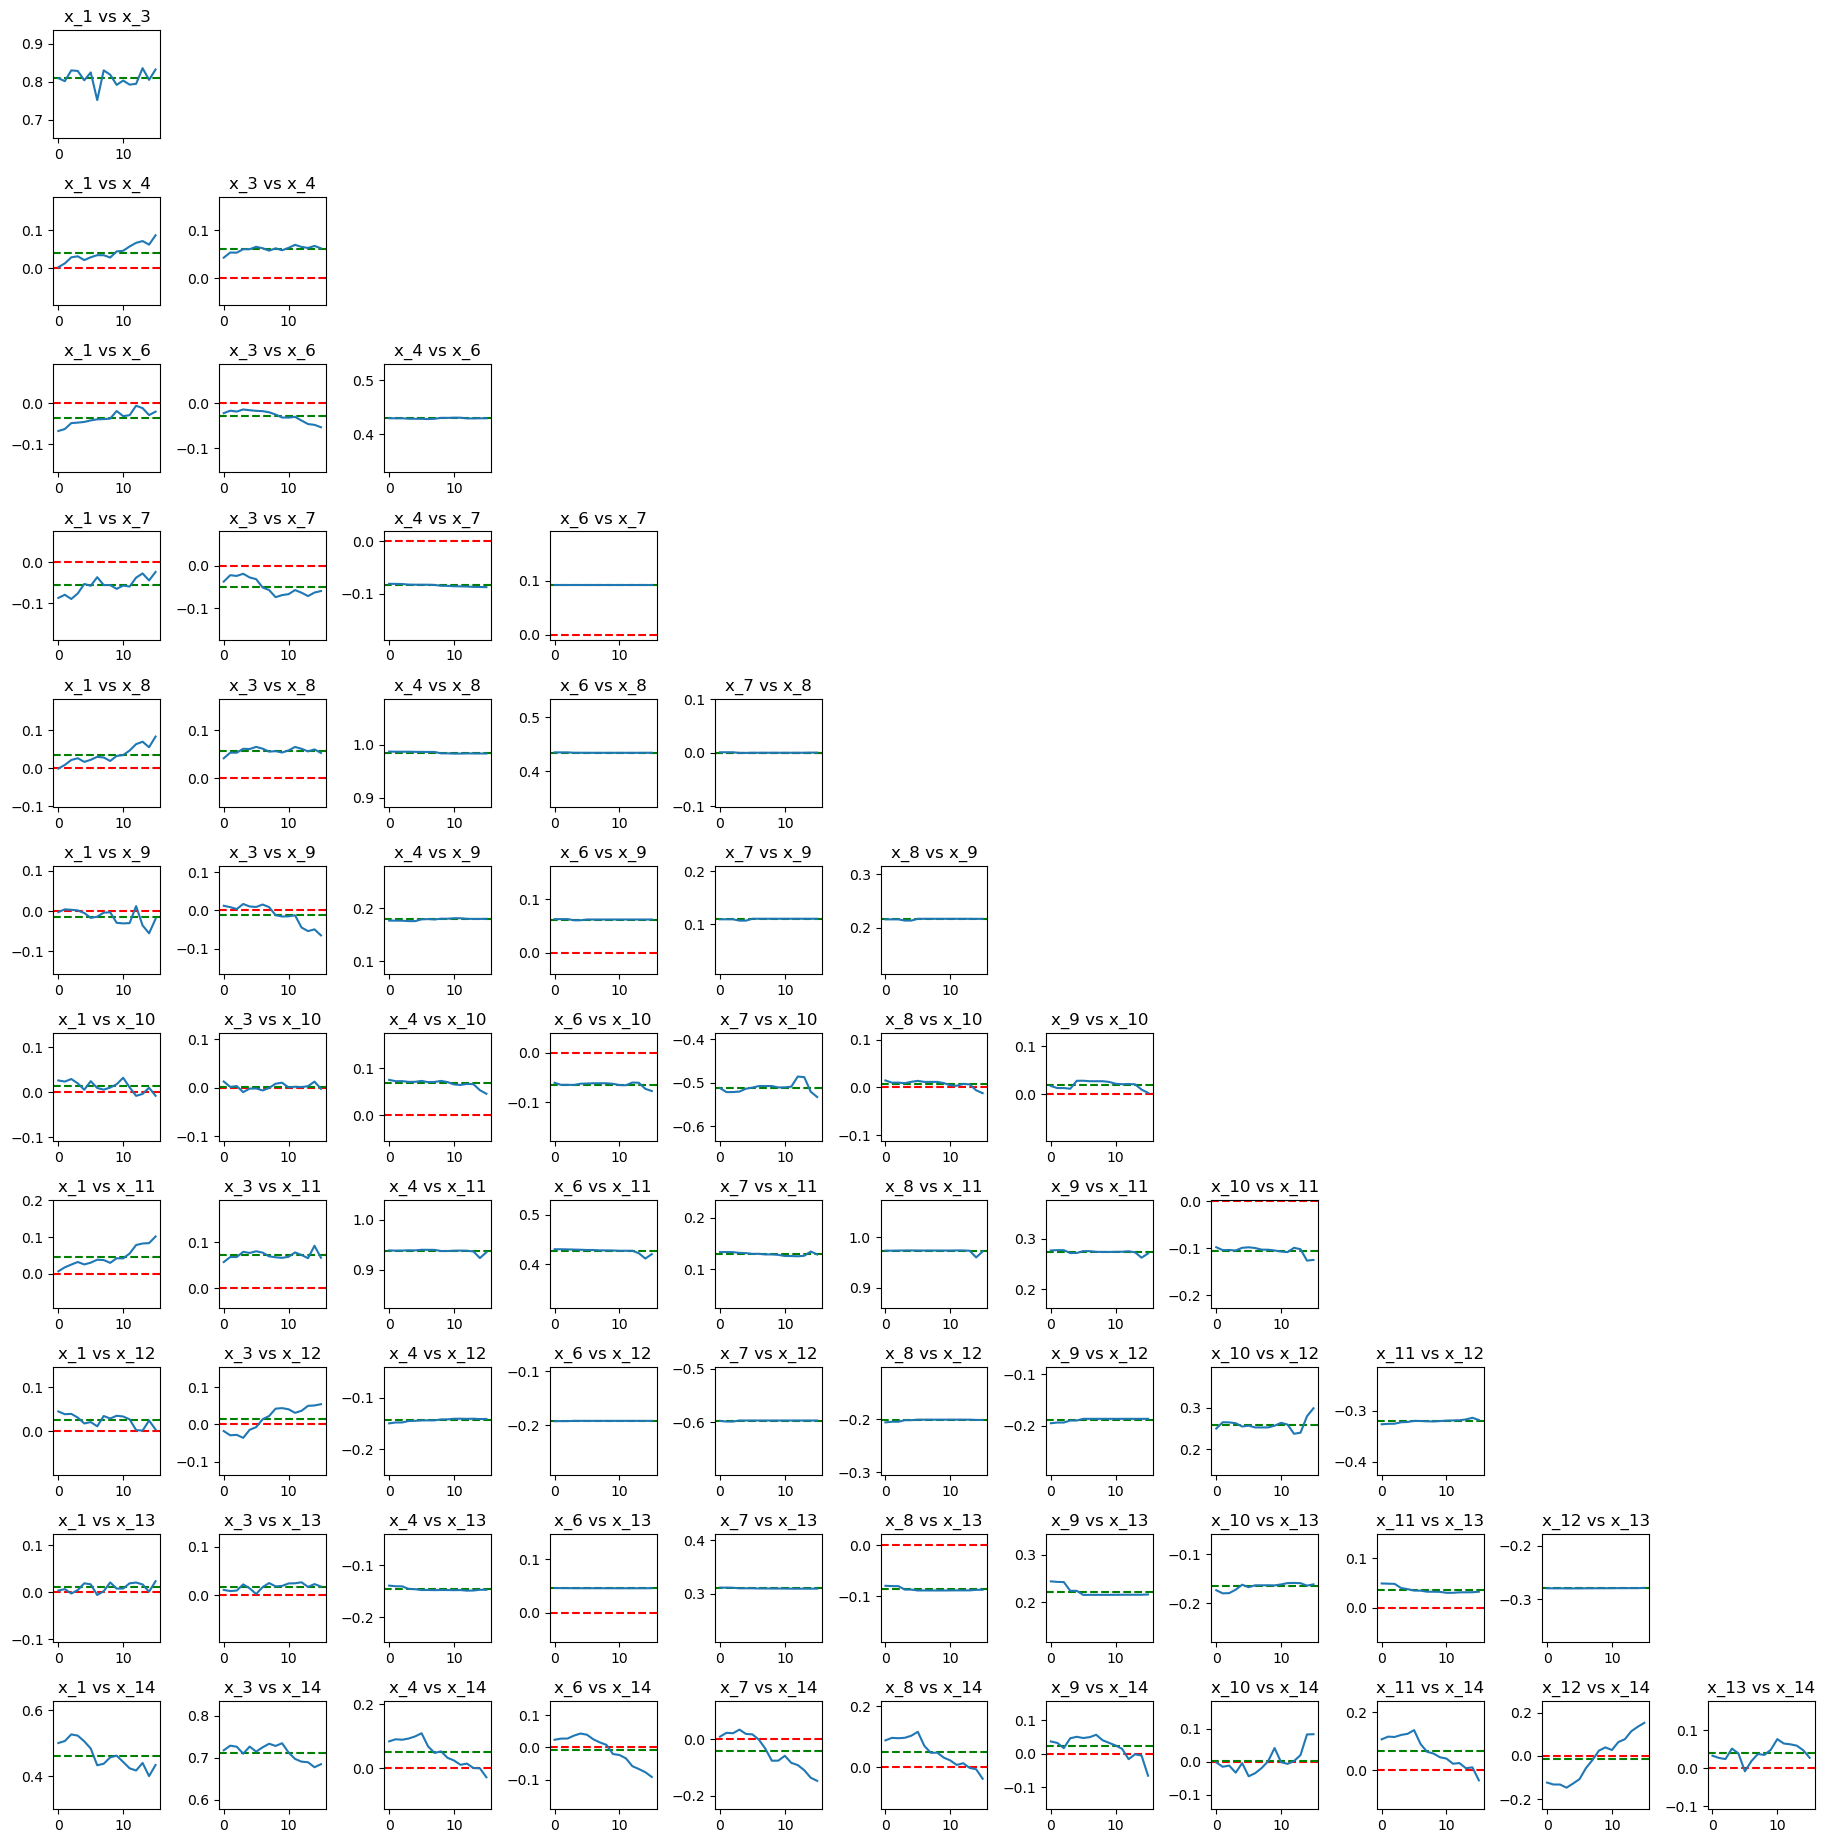

In [53]:
features = numcols.columns.tolist()
num_features = len(features)
months = train_subset.date_code.unique()

# Prepare the figure
plt.figure(figsize=(20, 20))  # Adjust the size as needed
for i in range(num_features):
    for j in range(num_features):
        # Plot only for lower triangular and non-diagonal elements
        if i > j:
            plt.subplot(num_features, num_features, i * num_features + j + 1)
            
            # Extract the time series of the correlation for this pair of features
            time_series = npres[:, i, j]
            plt.axhline(y=0, color='r', linestyle='--')
            plt.axhline(y=np.mean(time_series), color='green', linestyle='--')
            plt.plot(months, time_series)
            # Use feature names for titles
            plt.title(f'{features[j]} vs {features[i]}')
            plt.ylim(min(time_series)-0.1, max(time_series)+0.1)  # Correlation values range from -1 to 1
plt.tight_layout()
plt.savefig("../imgs/1_dataprep/correlation_history_plot.png", dpi=300)

plt.show()


# Miscelaneous Plots

In [54]:
from utils.constants import date_code_mapping
# Inverting the dictionary to map date codes to date strings
code_to_date_mapping = {v: k for k, v in date_code_mapping.items()}
train_dummy = train_subset.copy()
# Transforming date_code in train_subset to date strings
train_dummy['date_string'] = train_dummy['date_code'].map(code_to_date_mapping)
train_dummy['date_string'] = pd.to_datetime(train_dummy['date_string'])
# Display the updated DataFrame

test_dummy = test_subset.copy()
# Transforming date_code in train_subset to date strings
test_dummy['date_string'] = test_dummy['date_code'].map(code_to_date_mapping)
test_dummy['date_string'] = pd.to_datetime(test_dummy['date_string'])

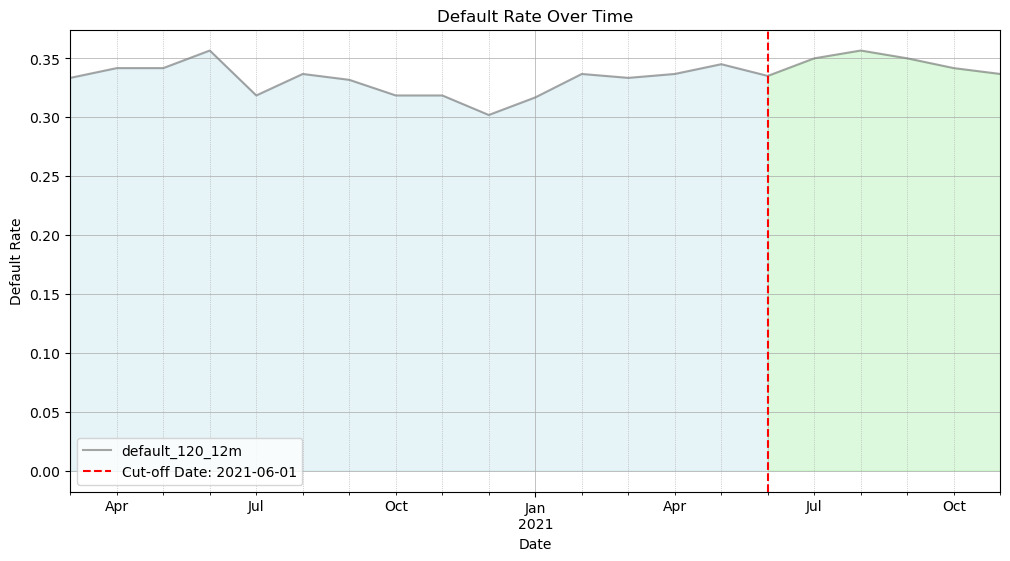

In [55]:
train_dfr = train_dummy.groupby('date_string')['default_120_12m'].mean()
test_dfr = test_dummy.groupby('date_string')['default_120_12m'].mean()
dfr = pd.concat([train_dfr, test_dfr], axis=0)

# Plotting
plt.figure(figsize=(12, 6))  # Set the figure size
dfr.plot(kind='line', color='gray', alpha=0.7)  # Kind of plot and color

# Filling the area under the curve
plt.fill_between(dfr[dfr.index <= train_dfr.index.max()].index, dfr[dfr.index <= train_dfr.index.max()], color='lightblue', alpha=0.3)
plt.fill_between(dfr[dfr.index >= train_dfr.index.max()].index, dfr[dfr.index >= train_dfr.index.max()], color='lightgreen', alpha=0.3)

# Add a vertical line
plt.axvline(x='2021-06-01', color='r', linestyle='--', label='Cut-off Date: 2021-06-01')

plt.grid(which='major', linestyle='-', linewidth='0.5', color='darkgray')  # Major grid lines
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='darkgray')  # Minor grid lines

plt.xlabel('Date')
plt.ylabel('Default Rate')
plt.title('Default Rate Over Time')

# Add legend
plt.legend()
plt.savefig("../imgs/1_dataprep/subset_default_rate_history.png", dpi=300)
# Show plot
plt.show()


# Save Final Dataset

In [56]:
train_sublist = train_subset.client_id.unique().tolist()
test_sublist = test_subset.client_id.unique().tolist()

SAVE = False
if SAVE:
    # Write the content of the first variable to the file
    with open('../model/utils/constants.py', 'w') as file:
        file.write("train_client_sublist = {}\n".format(train_sublist))
        file.write("test_client_sublist = {}\n".format(test_sublist))
        file.write("col_legibility_mapping = {}\n".format(col_legibility_mapping))
        file.write("date_code_mapping = {}\n".format(date_code_mapping))



    train_subset.to_csv('../data/dataset_1/processed/train_subset.csv', index=False)
    test_subset.to_csv('../data/dataset_1/processed/test_subset.csv', index=False)

In [77]:
import os
def print_directory_paths(directory):
    for root, dirs, _ in os.walk(directory):
        for name in dirs:
            print(os.path.relpath(os.path.join(root, name), directory))

# Replace 'your_directory_path' with the path of the folder you want to inspect
print_directory_paths('../')

imgs
model
envs
data
imgs/1_dataprep
imgs/2_modeling
model/output
model/utils
model/logs
model/output/binary
model/output/multiclass
model/utils/__pycache__
model/logs/binary
model/logs/multiclass
model/logs/binary/dqn
model/logs/binary/ddqn
model/logs/binary/dueldqn
model/logs/binary/ppo
model/logs/binary/a2c
model/logs/binary/trpo
model/logs/multiclass/dqn
model/logs/multiclass/trpo
data/dataset_2
data/dataset_1
data/dataset_2/raw
data/dataset_1/processed
data/dataset_1/raw


In [84]:
original_features = ['mispay_days','mispay_d_90d_12m', 'total_balance',
       'income', 'age', 'mortgage', 'mortgage_qty',
       'maturity_months', 'monthly_payment', 'subsidy', 'interest_rate',
       'default_120_12m']

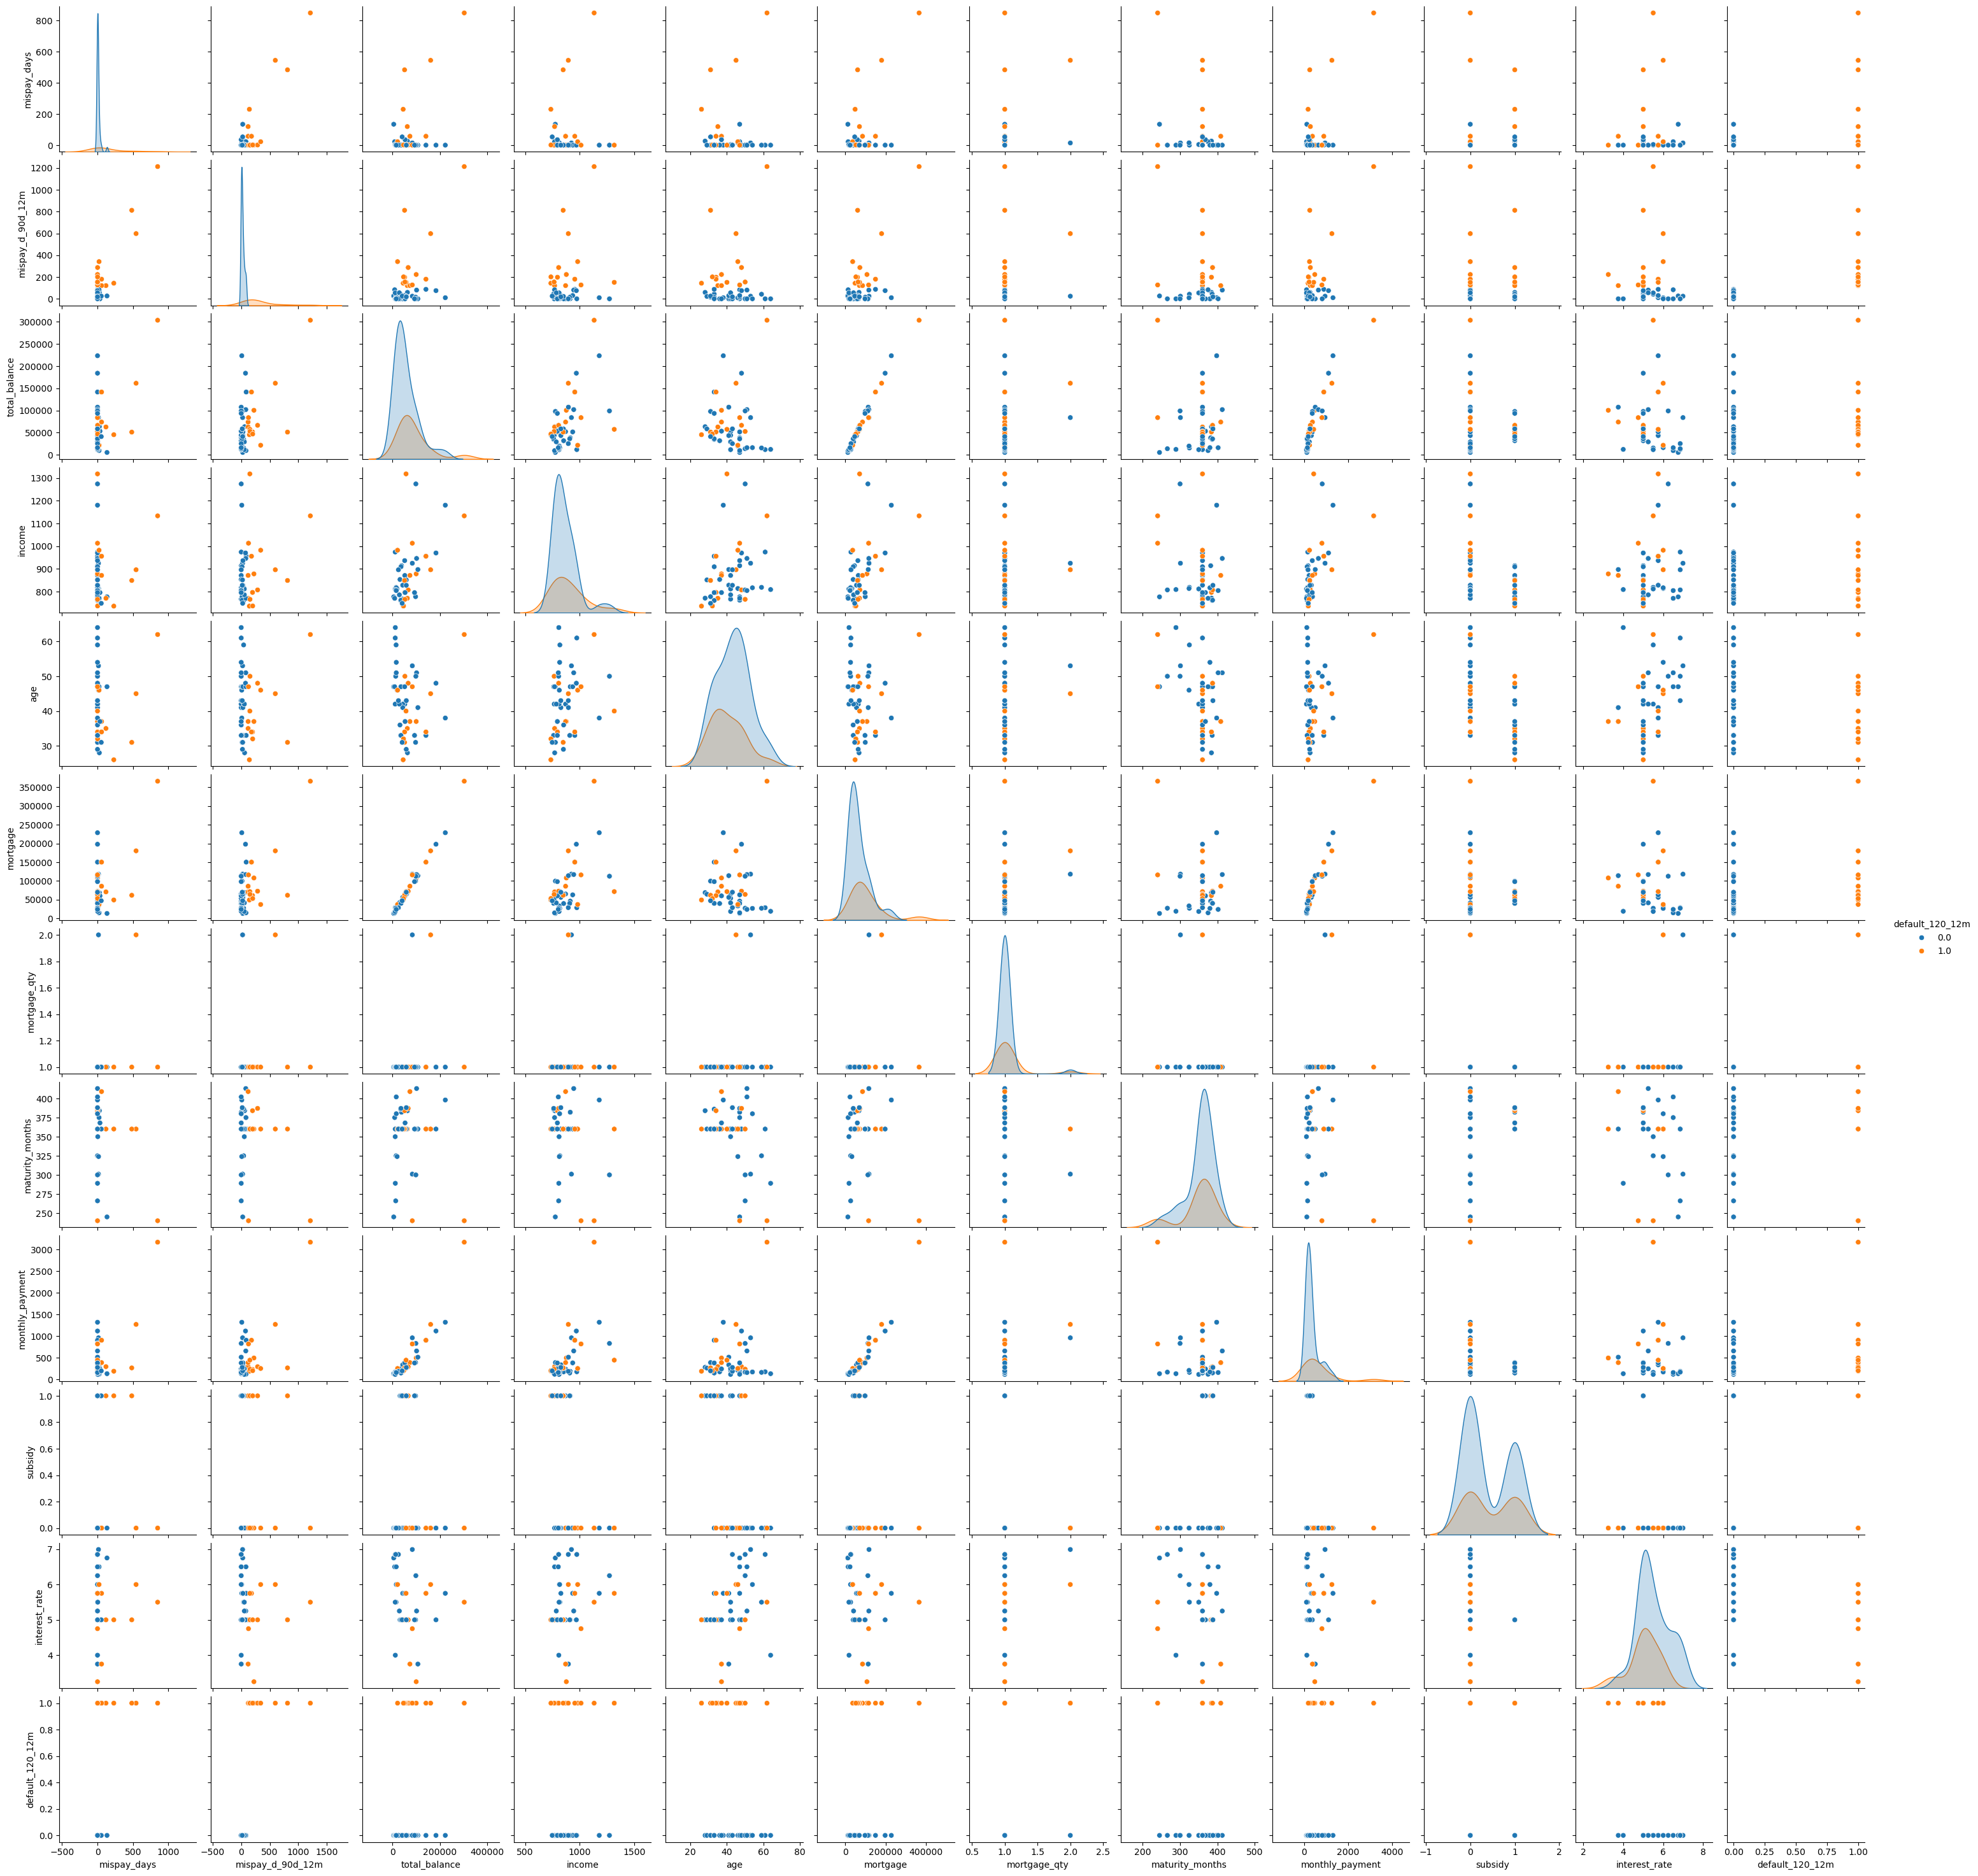

In [87]:
sns.pairplot(train_subset.sample(50), hue="default_120_12m", vars=original_features)

In [91]:
train_subset.client_id.unique().shape, test_subset.client_id.unique().shape, train_subset.shape, test_subset.shape, train_subset.shape[0] + test_subset.shape[0]

((603,), (603,), (9648, 14), (3015, 14), 12663)